In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import itertools
from sklearn.manifold import TSNE
from matplotlib import rcParams
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

In [2]:
rcParams['font.family'] = 'Helvetica'

In [3]:
dihedsFL = pd.read_csv("./Data/dihedsFL.csv").drop("Unnamed: 0", axis=1)
dihedsFL_interesting = pd.read_csv("./Data/dihedsFL_interesting.csv").drop("Unnamed: 0", axis=1)
dihedsFL_DBD_interesting = pd.read_csv("./Data/dihedsFL_DBD_interesting.csv").drop("Unnamed: 0", axis=1)
dihedsDBD = pd.read_csv("./Data/dihedsDBD.csv").drop("Unnamed: 0", axis=1)
dihedsDBD_interesting = pd.read_csv("./Data/dihedsDBD_interesting.csv").drop("Unnamed: 0", axis=1)
dihedsFL_DBD_AND_DBD = pd.read_csv("./Data/dihedsFL_DBD_AND_DBD.csv").drop("Unnamed: 0", axis=1)
dihedsFL_DBD_AND_DBD_interesting = pd.read_csv("./Data/dihedsFL_DBD_AND_DBD_interesting.csv").drop("Unnamed: 0", axis=1)

In [4]:
def Sillhouette(diheds2, title, fileName, labels):
    fig = plt.figure(figsize=(15, 7), layout="constrained")
    subfigs = fig.subfigures(1, 2)
    axes = subfigs[0].subplots(3, 3)
    axes = axes.flatten()

    # fig, axes = plt.subplots(2, 3, figsize=(9, 7), layout="constrained")
    # axes = axes.flatten()

    silhouette_avg_values = []
    for index, (clust, ax) in enumerate(zip(labels, axes)):
        if index == 0:
            silhouette_avg_values.append(0)
            continue
        n_clusters = index + 1

        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(diheds2) + (n_clusters + 1) * 10])

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        cluster_labels = clust.predict(diheds2)
        silhouette_avg = silhouette_score(diheds2, cluster_labels)
        silhouette_avg_values.append(silhouette_avg)

        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(diheds2, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title(f"{n_clusters} Clusters")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    subfigs[0].suptitle(f"Silhouette Analysis 1 ≤ k ≤ {n_clusters} Clusters", fontsize=15)

    ax = subfigs[1].subplots(1,1)
    ax.plot(range(1, 10), silhouette_avg_values, "o-")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Average Silhouette Score")
    
    fig.suptitle(title, fontsize=20)
    
    subfigs[1].suptitle("Average Silhouette Score vs Number of Clusters")
    
    plt.savefig(fileName, bbox_inches="tight", dpi=300)
    plt.show()

In [5]:
def ClusterHistogram(optimal, title, fileName):
    clusterColors = [
        (0.7, 0.3, 0.4),
        (1.0, 0.87, 0.37),
        (0.65, 0.9, 0.65),
        (1.0, 0.6, 0.6),
        (0.8, 1.0, 1.0),
        (0.0, 0.5, 1.0),
    ]

    fig, ax = plt.subplots(1, 1)
    x, y = np.unique(optimal.labels_, return_counts=True)
    ax.bar(x, y/max(y), color=clusterColors)
    ax.set_xlabel("Cluster Number")
    ax.set_ylabel("Relative Frequency")
    fig.suptitle(title, fontsize=15)
    plt.savefig(fileName, bbox_inches="tight", dpi=300)
    plt.show()

In [6]:
def Centroids(numClusts, diheds2, optimal, file):
    distToClusts = {i: (np.inf, -1) for i in range(numClusts)}
    for frameNum in range(diheds2.shape[0]):
        for clustNum, y in enumerate(optimal.cluster_centers_):
            x = diheds2.iloc[[frameNum]].to_numpy()
            dist = ((x - y) ** 2).sum() ** 0.5
            if dist < distToClusts[clustNum][0]:
                distToClusts[clustNum] = (dist, frameNum)
                
    return distToClusts

In [7]:
def DoKMedoids(df, clustsToConsider, title, location):
    wcss = []
    labels = []
    
    for i in range(1, clustsToConsider):
        kmeans = KMedoids(n_clusters=i, method="pam")
        cluster_labels = kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        labels.append(cluster_labels)
        print(i)
    
    fig, ax = plt.subplots(1, 1)
    ax.scatter(range(1, clustsToConsider), wcss/max(wcss))
    plt.suptitle(title, fontsize=15)
    ax.set_xlabel("Number of Clusters")
    plt.savefig(location, bbox_inches="tight", dpi=300)
    plt.show()
    
    return wcss, labels

In [8]:
def CalcDistances(df, optimal):
    dists = {i: [] for i in range(2)}
    for frameNum in range(df.shape[0]):
        for clustNum, y in enumerate(optimal.cluster_centers_):
            x = df.iloc[[frameNum]].to_numpy()
            dist = ((x - y) ** 2).sum() ** 0.5
            dists[clustNum].append(dist)
            
    return dists

In [9]:
def SaveDistsToFile(dists, df, location, optimal):
    rmsdSpreadsheet = pd.DataFrame(
    data = {
        "Frame": list(range(df.shape[0])),
        "Cluster": optimal.labels_
    } | {
        f"{x}": dists[x] for x in range(2)
    })

    rmsdSpreadsheet.to_csv(location, sep=" ", index=None)

In [13]:
def CalcDistsBetween2Clusters(df, centroidFrames, title, location, threshold, startAngle):
    fig, ax = plt.subplots()

    dists = []

    clust1_phi = df.iloc[[centroidFrames[0][1]]][df.columns[::2]]
    clust1_psi = df.iloc[[centroidFrames[0][1]]][df.columns[1::2]]
    clust2_phi = df.iloc[[centroidFrames[1][1]]][df.columns[::2]]
    clust2_psi = df.iloc[[centroidFrames[1][1]]][df.columns[1::2]]

    for x in range(clust1_phi.shape[1]):
        angle1 = clust1_phi.iloc[:, x].iloc[0], clust1_psi.iloc[:, x].iloc[0]
        angle2 = clust2_phi.iloc[:, x].iloc[0], clust2_psi.iloc[:, x].iloc[0]
        minDist = 10000
        for a in [angle1[0] - 2*np.pi, angle1[0], angle1[0] + 2*np.pi]:
            for b in [angle1[1] - 2*np.pi, angle1[1], angle1[1] + 2*np.pi]:
                d = np.sqrt(np.power(a - angle2[0], 2) + np.power(b - angle2[1], 2))
                if d < minDist:
                    minDist = d
        dists.append(minDist)
        
#     print(df)
#     print(clust1_phi.shape[1])
#     print(dists)
#     print(len(dists))

    ax.plot(range(startAngle, startAngle+len(dists)), dists, c="royalblue")
    plt.suptitle(title, fontsize=15)
    ax.set_xlabel("($\phi$,$\psi$) Pair Number")
    ax.set_ylabel("Distance")
    ax.set_xlim(startAngle-1, startAngle+len(dists))
    ax.set_ylim(bottom=0)
    plt.savefig(location, bbox_inches="tight", dpi=300)
    
    dists = np.array(dists)
    peaks = []
    for x in list(zip(dists, range(startAngle, startAngle+len(dists)+2))):
        if x[0] > threshold:
            peaks.append(x)
    return peaks

In [14]:
def Ramachandran(peaks, df, colors, legend_elements, centroidFrames, titlePrefix, locationPrefix):
    for d in peaks:
        fig = plt.figure(layout='constrained')
        ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
        ax.set(aspect=1)
        angle=d[1]
        interval=3
        ax.scatter(df[f"phi:{angle}"][::interval], df[f"psi:{angle}"][::interval], c=colors[::interval], s=1)
        for x in centroidFrames.values():
            ax.scatter(df.iloc[[x[1]]][f"phi:{angle}"], df.iloc[[x[1]]][f"psi:{angle}"], c="limegreen", s=20, marker="*")
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        ax.set_xticks([-np.pi, -np.pi/2, np.pi/2, np.pi], minor=True)
        ax.set_yticks([-np.pi, -np.pi/2, np.pi/2, np.pi], minor=True)
        ax.set_xticklabels(["$-\pi$", r"$\frac{-\pi}{2}$", r"$\frac{\pi}{2}$", "$\pi$"], minor=True)
        ax.set_yticklabels(["$-\pi$", r"$\frac{-\pi}{2}$", r"$\frac{\pi}{2}$", "$\pi$"], minor=True)
        ax.set_xticks([0], minor=False)
        ax.set_yticks([0], minor=False)
        ax.set_xticklabels(["0"], minor=False)
        ax.set_yticklabels(["0"], minor=False)

        ax.tick_params(axis="both", which="minor")
        ax.grid(visible=True, which="minor", axis="both")
        ax.grid(visible=True, which="major", axis="both", lw=2, color="black")
        ax.set_axisbelow(True)

        ax.set_xlabel("$\phi$ angle")
        ax.set_ylabel("$\psi$ angle")

        ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
        ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

        for col in ["#0043CB", "#BF0202", "#FFC400", "#246210"]:
            points = zip(df[f"phi:{angle}"][::interval], df[f"psi:{angle}"][::interval], colors[::interval])
            WT = [(phi, psi) for (phi, psi, c) in points if c == col]

            kde = gaussian_kde([x[0] for x in WT])
            xx = np.linspace(-np.pi, np.pi, 1000)
            ax_histx.plot(xx, kde(xx), color=col)

            kde = gaussian_kde([x[1] for x in WT])
            xx = np.linspace(-np.pi, np.pi, 1000)
            ax_histy.plot(kde(xx), xx, color=col)

        ax_histx.tick_params(axis="x", which="both", labelbottom=False)
        ax_histx.tick_params(axis="y", left=False, labelleft=False)
        ax_histy.tick_params(axis="y", which="both", labelleft=False)
        ax_histy.tick_params(axis="x", bottom=False, labelbottom=False)

        ax.legend(handles=legend_elements, borderaxespad=0, bbox_to_anchor=(0.5, -0.2), ncol=2, loc="upper center", framealpha=0, edgecolor="white")

        plt.suptitle(f"{titlePrefix} $(\phi,\psi)_{{{angle}}}$", fontsize=15)
        plt.savefig(f"{locationPrefix}{angle}.png", bbox_inches="tight", dpi=300)

In [23]:
def Ramachandran2(peaks, df, colors, legend_elements, centroidFrames, titlePrefix, locationPrefix):
    # Create a figure with a grid of subplots, one for each angle
    fig, axes = plt.subplots(3, 3, figsize=(6,7), layout='constrained')
    fig.suptitle(f"{titlePrefix} $(\phi, \psi)$ Angles of Interest", fontsize=20)
    
    # If there's only one peak, make sure axes is treated as a list
    if len(peaks) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
        
    interval = 3

    for i, d in enumerate(peaks):
        ax = axes[i]
        ax.set(aspect=1)
        angle = d[1]

        # Scatter plot of phi and psi angles
        ax.scatter(df[f"phi:{angle}"][::interval], df[f"psi:{angle}"][::interval], c=colors[::interval], s=0.5)
        
        # Plot centroid points
        for x in centroidFrames.values():
            ax.scatter(df.iloc[[x[1]]][f"phi:{angle}"], df.iloc[[x[1]]][f"psi:{angle}"], c="limegreen", s=20, marker="*")
        
        # Set axis limits and ticks
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        ax.set_xticks([-np.pi, -np.pi/2, np.pi/2, np.pi], minor=True)
        ax.set_yticks([-np.pi, -np.pi/2, np.pi/2, np.pi], minor=True)
        ax.set_xticklabels(["$-\pi$", r"$\frac{-\pi}{2}$", r"$\frac{\pi}{2}$", "$\pi$"], minor=True)
        ax.set_yticklabels(["$-\pi$", r"$\frac{-\pi}{2}$", r"$\frac{\pi}{2}$", "$\pi$"], minor=True)
        ax.set_xticks([0], minor=False)
        ax.set_yticks([0], minor=False)
        ax.set_xticklabels(["0"], minor=False)
        ax.set_yticklabels(["0"], minor=False)

        # Enable grid and configure appearance
        ax.tick_params(axis="both", which="minor")
        ax.grid(visible=True, which="minor", axis="both")
        ax.grid(visible=True, which="major", axis="both", lw=2, color="black")
        ax.set_axisbelow(True)

        # Set axis labels
        ax.set_xlabel("$\phi$ angle")
        ax.set_ylabel("$\psi$ angle")

        # Create the inset axes for histograms
        ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
        ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

        # Plot KDEs for different colors
        for col in ["#0043CB", "#BF0202", "#FFC400", "#246210"]:
            points = zip(df[f"phi:{angle}"][::interval], df[f"psi:{angle}"][::interval], colors[::interval])
            WT = [(phi, psi) for (phi, psi, c) in points if c == col]

            kde = gaussian_kde([x[0] for x in WT])
            xx = np.linspace(-np.pi, np.pi, 1000)
            ax_histx.plot(xx, kde(xx), color=col, linewidth=1)

            kde = gaussian_kde([x[1] for x in WT])
            ax_histy.plot(kde(xx), xx, color=col, linewidth=1)

        # Hide ticks and labels for the histogram axes
        ax_histx.tick_params(axis="x", which="both", labelbottom=False)
        ax_histx.tick_params(axis="y", left=False, labelleft=False)
        ax_histy.tick_params(axis="y", which="both", labelleft=False)
        ax_histy.tick_params(axis="x", bottom=False, labelbottom=False)

        # Set the title for each subplot
        ax.set_title(f"$(\phi,\psi)_{{{angle}}}$", fontsize=15)

    # Add a legend for the entire figure
    fig.legend(handles=legend_elements, borderaxespad=0, bbox_to_anchor=(0.5, 0), ncol=2, loc="upper center", framealpha=0, edgecolor="white")

    for ax in axes[i+1:]:
        fig.delaxes(ax)
        
    width, height = fig.get_size_inches()
    fig.set_size_inches(width * 1.25, height * 1.25)
        
    # Save the combined plot as a single image file
    plt.savefig(f"{locationPrefix}all_angles.png", bbox_inches="tight", dpi=300)
    plt.show()

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2
3
4
5
6
7
8
9


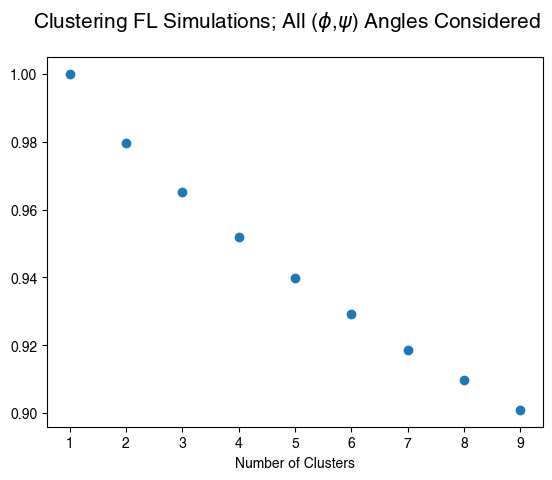

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2
3
4
5
6
7
8
9


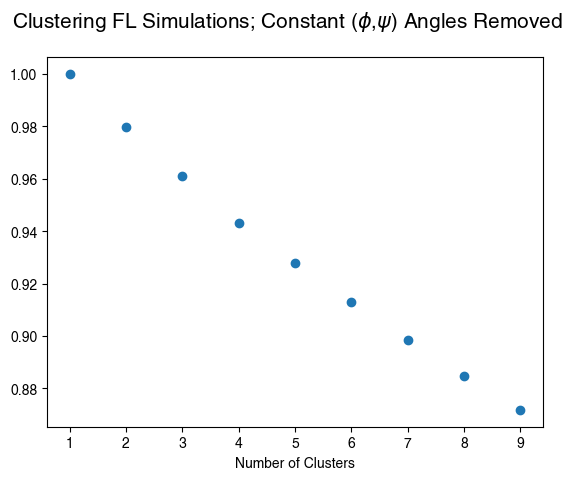

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2
3
4
5
6
7
8
9


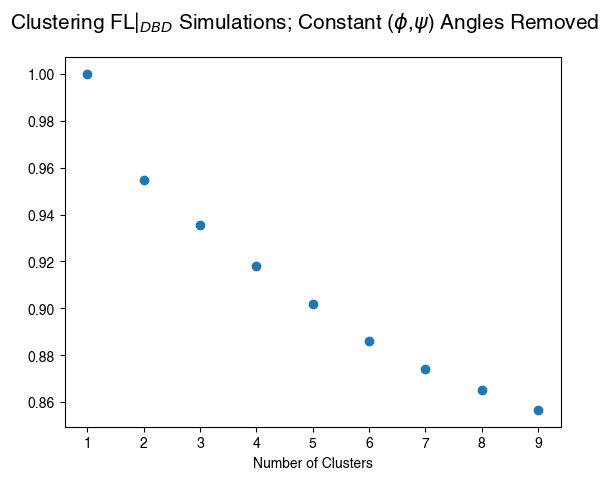

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2
3
4
5
6
7
8
9


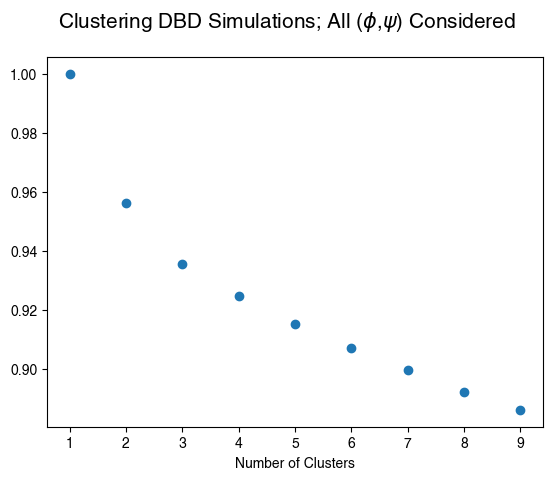

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2
3
4
5
6
7
8
9


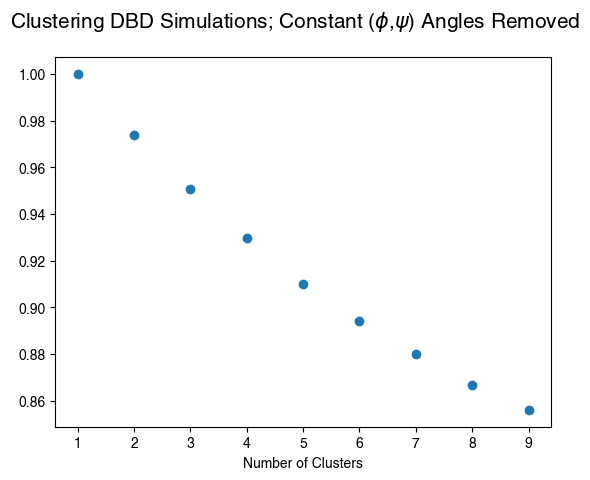

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2
3
4
5
6
7
8
9


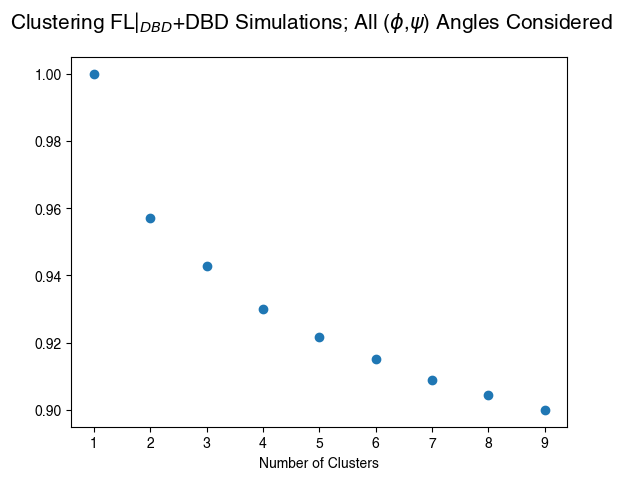

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2
3
4
5
6
7
8
9


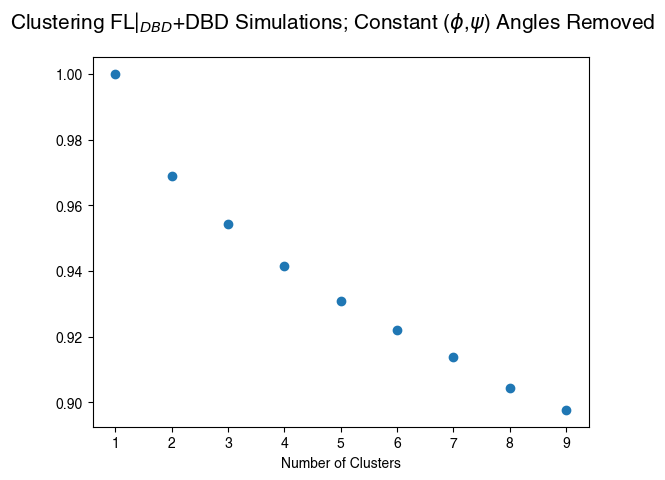

In [12]:
#Use this to generate full elbow plot
wcssFL, labelsFL = DoKMedoids(dihedsFL, 10, 
                              "Clustering FL Simulations; All ($\phi$,$\psi$) Angles Considered",
                              "/home/student5/Desktop/DihedralClustPlots/FL_AllAngles.png")
wcssFL_interesting, labelsFL_interesting = DoKMedoids(dihedsFL_interesting, 10, 
                              "Clustering FL Simulations; Constant ($\phi$,$\psi$) Angles Removed",
                              "/home/student5/Desktop/DihedralClustPlots/FL_interesting.png")
wcssFL_DBD_interesting, labelsFL_DBD_interesting = DoKMedoids(dihedsFL_DBD_interesting, 10, 
                              "Clustering FL|$_{{DBD}}$ Simulations; Constant ($\phi$,$\psi$) Angles Removed",
                              "/home/student5/Desktop/DihedralClustPlots/FL_DBD_interesting.png")
wcssDBD, labelsDBD = DoKMedoids(dihedsDBD, 10, 
                              "Clustering DBD Simulations; All ($\phi$,$\psi$) Considered",
                              "/home/student5/Desktop/DihedralClustPlots/DBD_AllAngles.png")
wcssDBD_interesting, labelsDBD_interesting = DoKMedoids(dihedsDBD_interesting, 10, 
                              "Clustering DBD Simulations; Constant ($\phi$,$\psi$) Angles Removed",
                              "/home/student5/Desktop/DihedralClustPlots/DBD_interesting.png")
wcssFL_DBD_AND_DBD, labelsFL_DBD_AND_DBD = DoKMedoids(dihedsFL_DBD_AND_DBD, 10, 
                              "Clustering FL|$_{{DBD}}$+DBD Simulations; All ($\phi$,$\psi$) Angles Considered",
                              "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_AllAngles.png")
wcssFL_DBD_AND_DBD_interesting, labelsFL_DBD_AND_DBD_interesting = DoKMedoids(dihedsFL_DBD_AND_DBD_interesting, 10, 
                              "Clustering FL|$_{{DBD}}$+DBD Simulations; Constant ($\phi$,$\psi$) Angles Removed",
                              "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_interesting.png")

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2


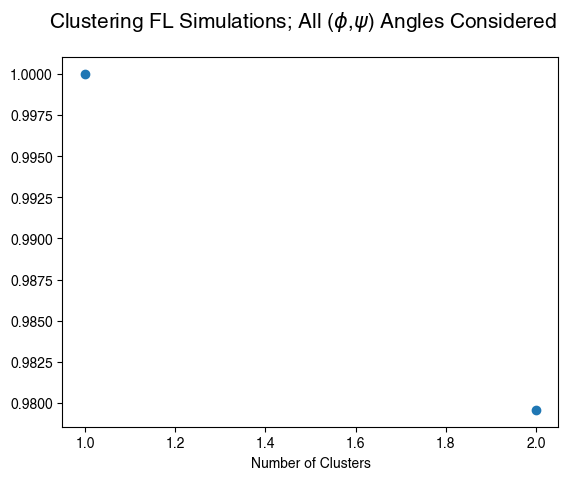

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2


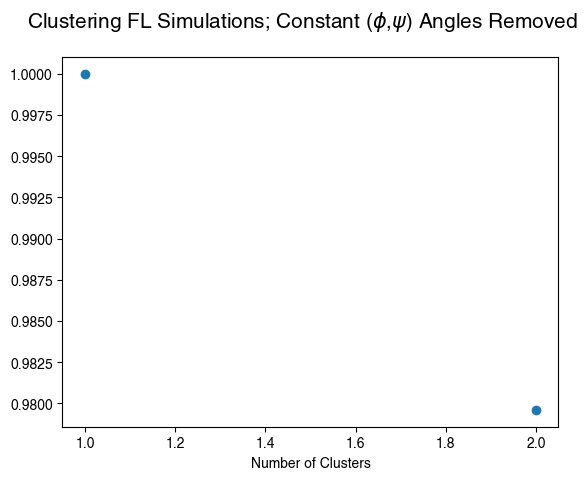

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2


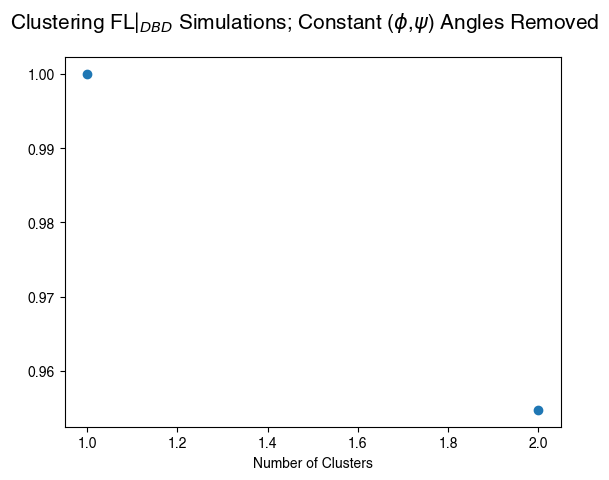

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2


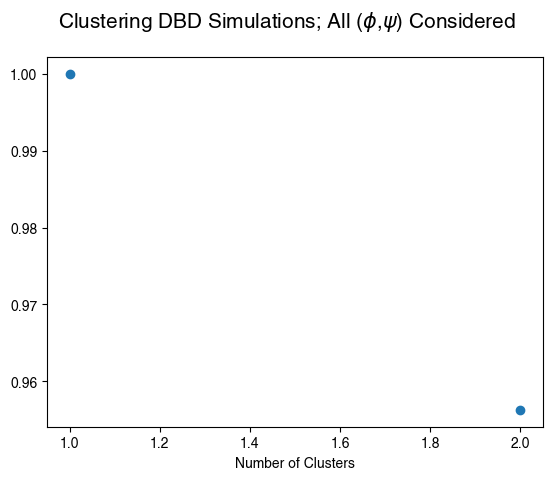

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2


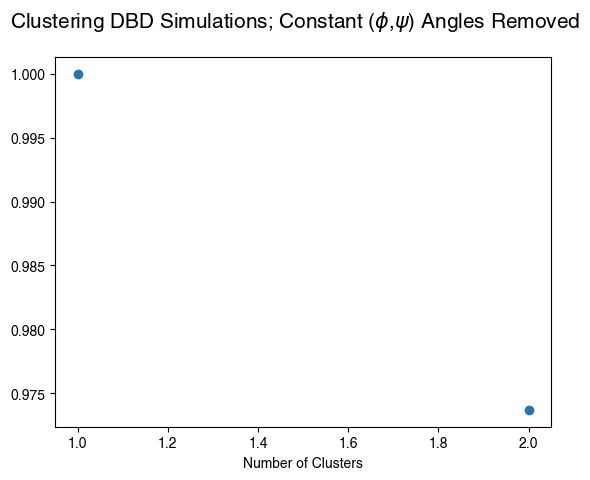

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2


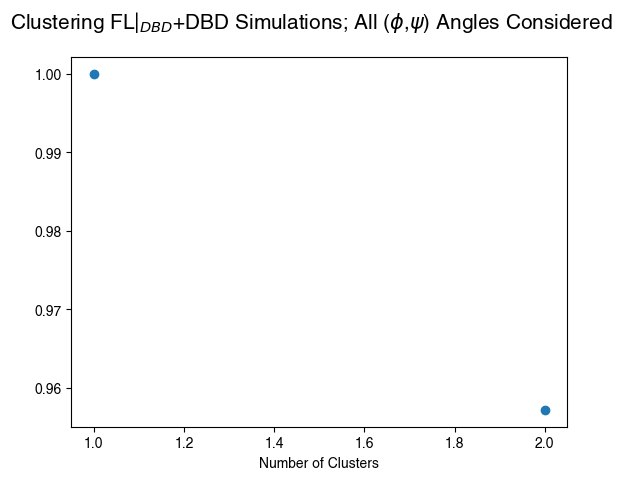

/home/student5/anaconda3/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(


1
2


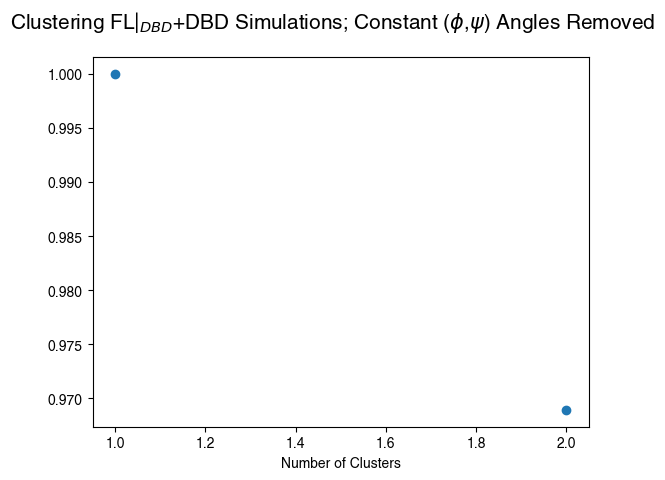

In [10]:
#Use this to just regenerate data!
wcssFL, labelsFL = DoKMedoids(dihedsFL, 3, 
                              "Clustering FL Simulations; All ($\phi$,$\psi$) Angles Considered",
                              "/home/student5/Desktop/DihedralClustPlots/FL_AllAngles.png")
wcssFL_interesting, labelsFL_interesting = DoKMedoids(dihedsFL_interesting, 3, 
                              "Clustering FL Simulations; Constant ($\phi$,$\psi$) Angles Removed",
                              "/home/student5/Desktop/DihedralClustPlots/FL_interesting.png")
wcssFL_DBD_interesting, labelsFL_DBD_interesting = DoKMedoids(dihedsFL_DBD_interesting, 3, 
                              "Clustering FL|$_{{DBD}}$ Simulations; Constant ($\phi$,$\psi$) Angles Removed",
                              "/home/student5/Desktop/DihedralClustPlots/FL_DBD_interesting.png")
wcssDBD, labelsDBD = DoKMedoids(dihedsDBD, 3, 
                              "Clustering DBD Simulations; All ($\phi$,$\psi$) Considered",
                              "/home/student5/Desktop/DihedralClustPlots/DBD_AllAngles.png")
wcssDBD_interesting, labelsDBD_interesting = DoKMedoids(dihedsDBD_interesting, 3, 
                              "Clustering DBD Simulations; Constant ($\phi$,$\psi$) Angles Removed",
                              "/home/student5/Desktop/DihedralClustPlots/DBD_interesting.png")
wcssFL_DBD_AND_DBD, labelsFL_DBD_AND_DBD = DoKMedoids(dihedsFL_DBD_AND_DBD, 3, 
                              "Clustering FL|$_{{DBD}}$+DBD Simulations; All ($\phi$,$\psi$) Angles Considered",
                              "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_AllAngles.png")
wcssFL_DBD_AND_DBD_interesting, labelsFL_DBD_AND_DBD_interesting = DoKMedoids(dihedsFL_DBD_AND_DBD_interesting, 3, 
                              "Clustering FL|$_{{DBD}}$+DBD Simulations; Constant ($\phi$,$\psi$) Angles Removed",
                              "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_interesting.png")

/tmp/ipykernel_71522/486341372.py:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(fileName, bbox_inches="tight", dpi=300)
/home/student5/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


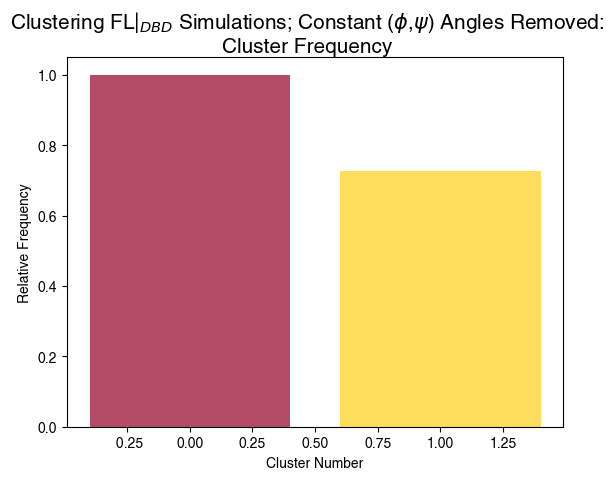

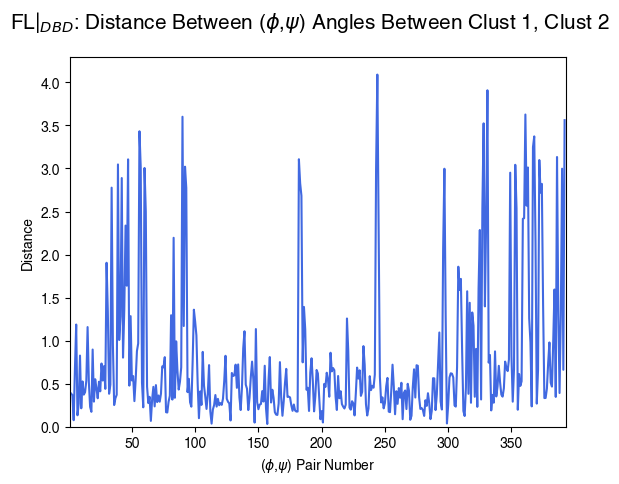

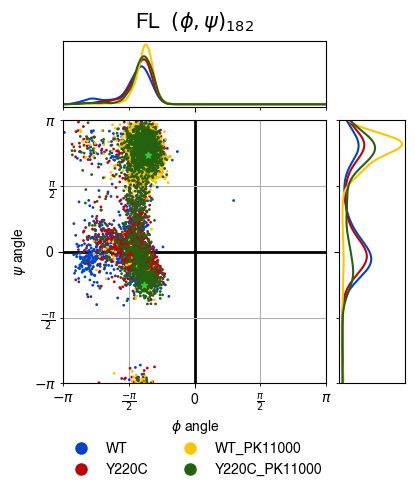

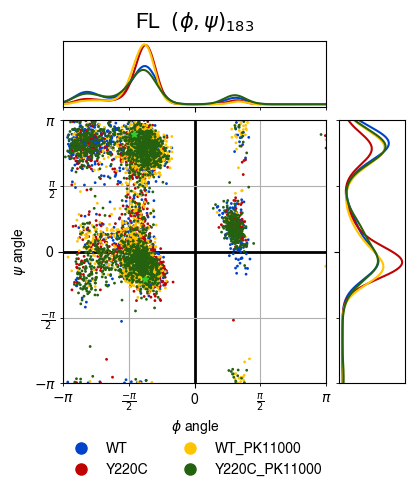

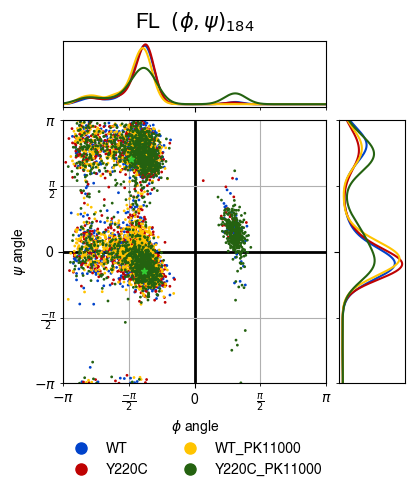

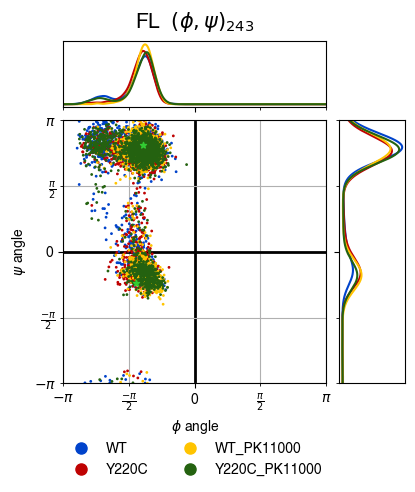

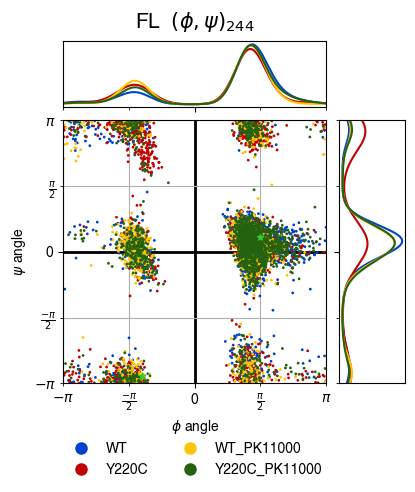

In [59]:
# Sillhouette(dihedsFL_DBD_interesting, "Clustering FL|$_{{DBD}}$ Simulations; Constant ($\phi$,-$\psi$) Angles Removed: Silhouette Analysis",
#             "/home/student5/Desktop/DihedralClustPlots/FL_interesting_Silhouette.png", labelsFL_DBD_interesting)
ClusterHistogram(labelsFL_DBD_interesting[1], "Clustering FL|$_{{DBD}}$ Simulations; Constant ($\phi$,$\psi$) Angles Removed:\nCluster Frequency",
                "/home/student5/Desktop/DihedralClustPlots/FL_interesting_ClustFreq.png")
centroidFrames = Centroids(2, dihedsFL_DBD_interesting, labelsFL_DBD_interesting[1],
          "/home/student5/Desktop/DihedralClustPlots/FL_interesting_Centroids.csv")
dists = CalcDistances(dihedsFL_DBD_interesting, labelsFL_DBD_interesting[1])
SaveDistsToFile(dists, dihedsFL, "/home/student5/Desktop/DihedralClustPlots/FL_DBD_interesting.dat", labelsFL_DBD_interesting[1])
peaks = CalcDistsBetween2Clusters(dihedsFL, centroidFrames, 
                          "FL|$_{{DBD}}$: Distance Between ($\phi$,$\psi$) Angles Between Clust 1, Clust 2",
                        "/home/student5/Desktop/DihedralClustPlots/FL_DBD_DistBetweenClusts.png", 2.5, 2)
peaks2 = [p for p in peaks if 97 <= p[1] <= 288]
c = ["#0043CB", "#BF0202", "#FFC400",    "#246210"]
l = ["WT",      "Y220C",   "WT_PK11000", "Y220C_PK11000"]
legend_elements = []
for col, lab in zip(c, l):
    legend_elements.append(Line2D([0], [0], marker='o', color=col, label=lab, markersize=8, linestyle=''))
colors = [c[x] for x in np.arange(0, dihedsFL.shape[0]) // 5986]
Ramachandran(peaks2, dihedsFL, colors, legend_elements, centroidFrames, "FL ", "/home/student5/Desktop/DihedralClustPlots/FL_PhiPsi")

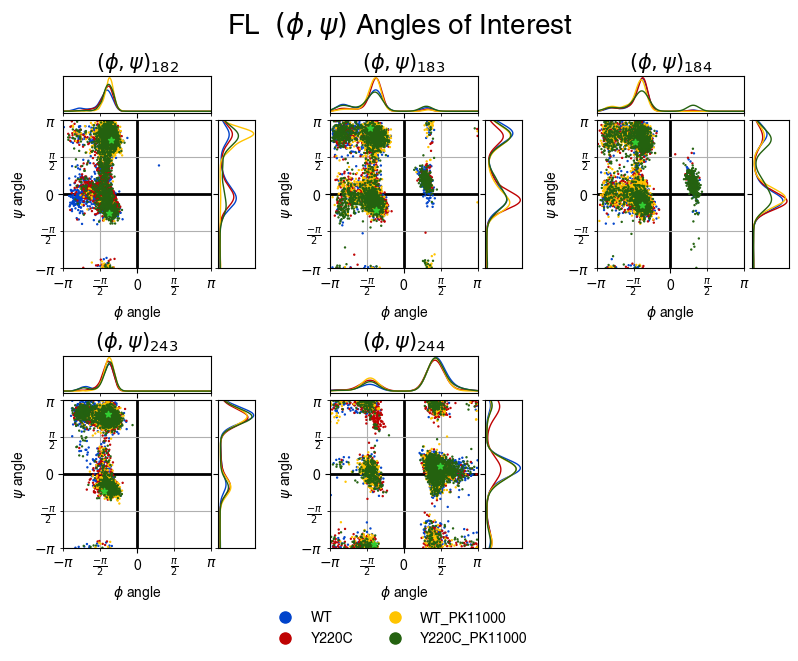

In [86]:
Ramachandran2(peaks2, dihedsFL, colors, legend_elements, centroidFrames, "FL ", "/home/student5/Desktop/DihedralClustPlots/FL_PhiPsi")

In [88]:
centroidFrames

{0: (0.0, 12343), 1: (0.0, 19094)}

/tmp/ipykernel_87410/486341372.py:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(fileName, bbox_inches="tight", dpi=300)
/home/student5/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


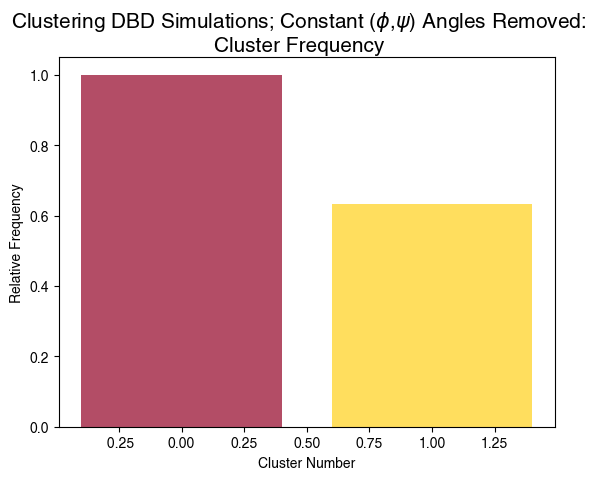

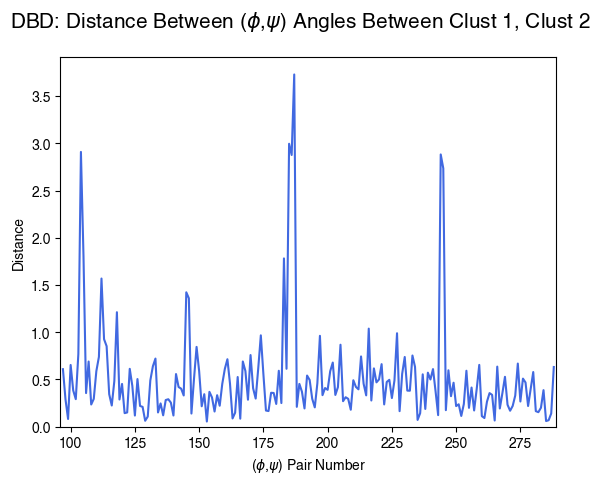

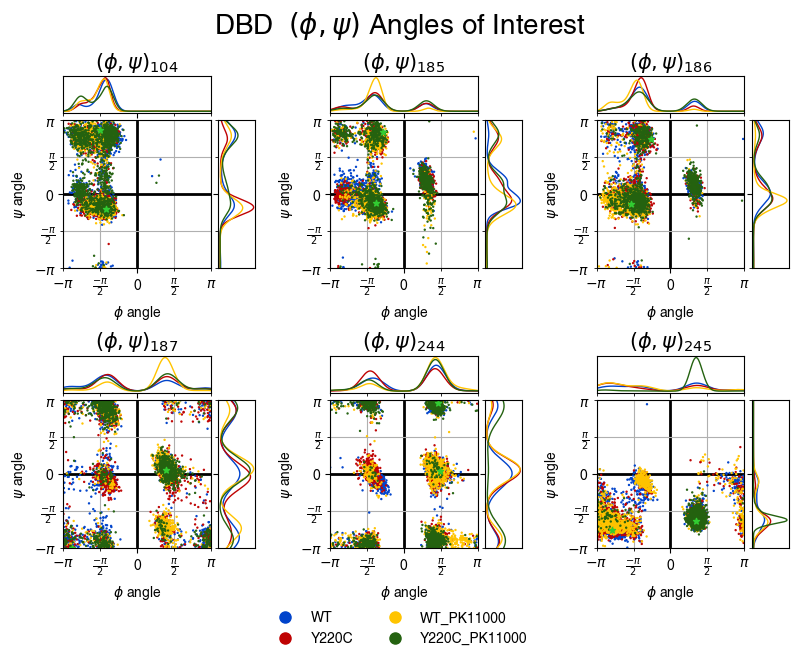

In [16]:
# Sillhouette(dihedsDBD_interesting, "Clustering DBD Simulations; Constant ($\phi$,-$\psi$) Angles Removed: Silhouette Analysis",
#             "/home/student5/Desktop/DihedralClustPlots/DBD_interesting_Silhouette.png", labelsDBD_interesting)
ClusterHistogram(labelsDBD_interesting[1], "Clustering DBD Simulations; Constant ($\phi$,$\psi$) Angles Removed:\nCluster Frequency",
                "/home/student5/Desktop/DihedralClustPlots/DBD_interesting_ClustFreq.png")
centroidFrames = Centroids(2, dihedsDBD_interesting, labelsDBD_interesting[1],
          "/home/student5/Desktop/DihedralClustPlots/DBD_interesting_Centroids.csv")
dists = CalcDistances(dihedsDBD_interesting, labelsDBD_interesting[1])
SaveDistsToFile(dists, dihedsDBD, "/home/student5/Desktop/DihedralClustPlots/DBD_interesting.dat", labelsDBD_interesting[1])
peaks = CalcDistsBetween2Clusters(dihedsDBD, centroidFrames, 
                          "DBD: Distance Between ($\phi$,$\psi$) Angles Between Clust 1, Clust 2",
                        "/home/student5/Desktop/DihedralClustPlots/DBD_DistBetweenClusts.png", 2.5, 97)
c = ["#0043CB", "#BF0202", "#FFC400",    "#246210"]
l = ["WT",      "Y220C",   "WT_PK11000", "Y220C_PK11000"]
legend_elements = []
for col, lab in zip(c, l):
    legend_elements.append(Line2D([0], [0], marker='o', color=col, label=lab, markersize=8, linestyle=''))
colors = [c[x] for x in np.arange(0, dihedsDBD.shape[0]) // 3996]
Ramachandran2(peaks, dihedsDBD, colors, legend_elements, centroidFrames, "DBD ", "/home/student5/Desktop/DihedralClustPlots/DBD_PhiPsi")

/tmp/ipykernel_87410/486341372.py:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(fileName, bbox_inches="tight", dpi=300)
/home/student5/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


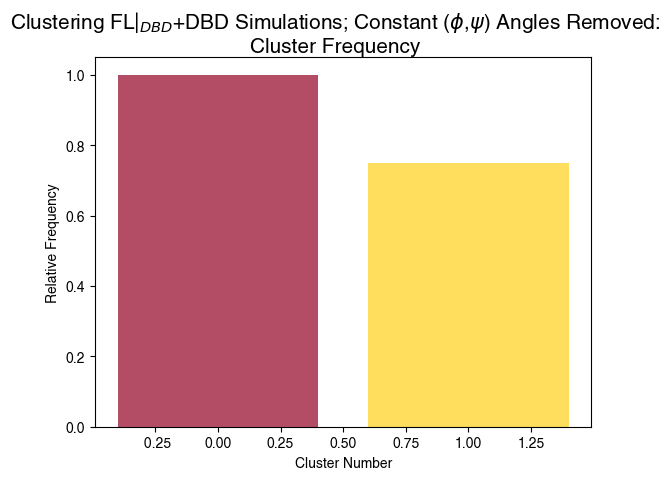

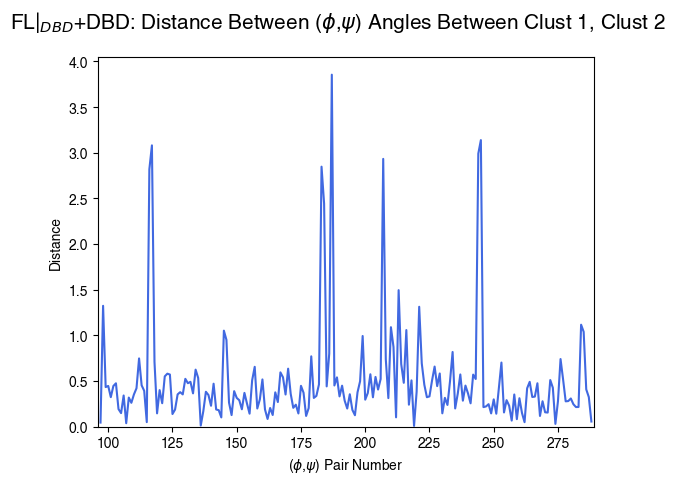

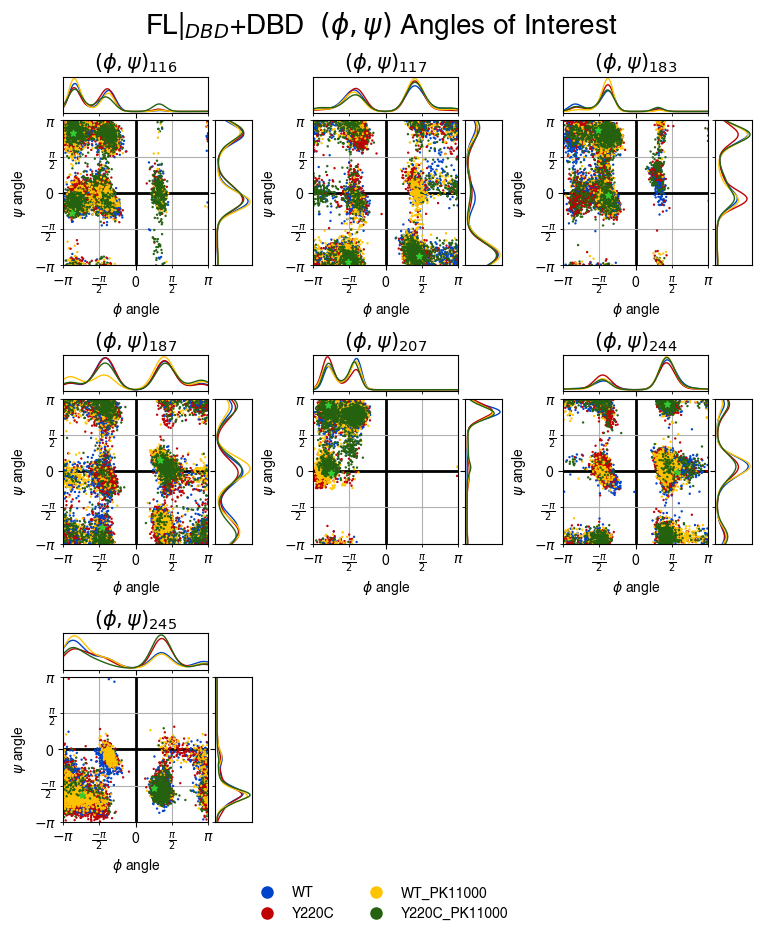

In [24]:
# Sillhouette(dihedsFL_DBD_AND_DBD_interesting, "Clustering FL|$_{{DBD}}$+DBD Simulations; Constant ($\phi$,-$\psi$) Angles Removed: Silhouette Analysis",
#             "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_interesting_Silhouette.png", labelsFL_DBD_AND_DBD_interesting)
ClusterHistogram(labelsFL_DBD_AND_DBD_interesting[1], "Clustering FL|$_{{DBD}}$+DBD Simulations; Constant ($\phi$,$\psi$) Angles Removed:\nCluster Frequency",
                "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_interesting_ClustFreq.png")
centroidFrames = Centroids(2, dihedsFL_DBD_AND_DBD_interesting, labelsFL_DBD_AND_DBD_interesting[1],
          "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_interesting_Centroids.csv")
dists = CalcDistances(dihedsFL_DBD_AND_DBD_interesting, labelsFL_DBD_AND_DBD_interesting[1])
SaveDistsToFile(dists, dihedsFL_DBD_AND_DBD, "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_interesting.dat", labelsFL_DBD_AND_DBD_interesting[1])
peaks = CalcDistsBetween2Clusters(dihedsFL_DBD_AND_DBD, centroidFrames, 
                          "FL|$_{{DBD}}$+DBD: Distance Between ($\phi$,$\psi$) Angles Between Clust 1, Clust 2",
                        "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_DistBetweenClusts.png", 2.5, 97)
c = ["#0043CB", "#BF0202", "#FFC400",    "#246210"]
l = ["WT",      "Y220C",   "WT_PK11000", "Y220C_PK11000"]
legend_elements = []
for col, lab in zip(c, l):
    legend_elements.append(Line2D([0], [0], marker='o', color=col, label=lab, markersize=8, linestyle=''))
colors = [c[x] for x in np.arange(0, dihedsFL.shape[0]) // 5986] + [c[x] for x in np.arange(0, dihedsDBD.shape[0]) // 3996]
Ramachandran2(peaks, dihedsFL_DBD_AND_DBD, colors, legend_elements, centroidFrames, "FL|$_{{DBD}}$+DBD ", "/home/student5/Desktop/DihedralClustPlots/FL_DBD_AND_DBD_PhiPsi")